In [1]:
from __future__ import print_function, division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from scipy import stats
import matplotlib.ticker as ticker


In [2]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

## Loading data

In [3]:
data_dir = 'data/'

waveforms = {}

for item in os.listdir(data_dir):
    full_path = os.path.join(data_dir, item)
    waveforms[item.rstrip('.txt')] = pd.read_csv(full_path, sep='\t', index_col=0)

inspecting first of the waveforms

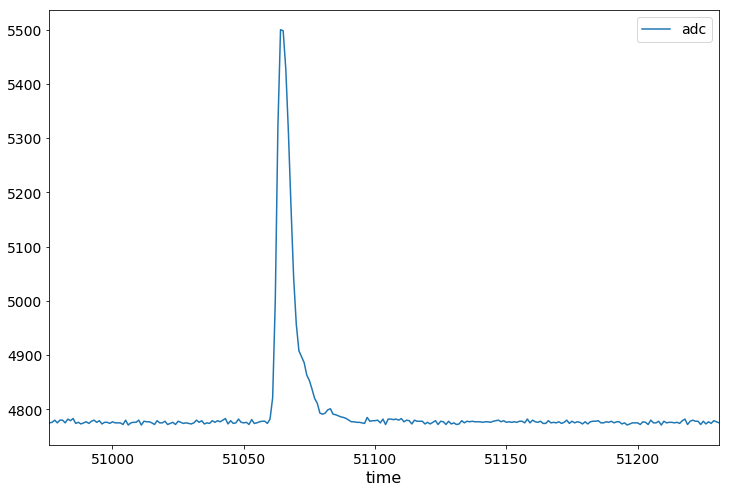

In [4]:
waveforms[list(waveforms)[0]].plot('time', 'adc')

Cutting out the noise from the waveforms

In [5]:
noise = []
for df in waveforms.values():
    noise.append(df['adc'][df['adc'] <= (2. * df['adc'].median()) - df['adc'].min()])

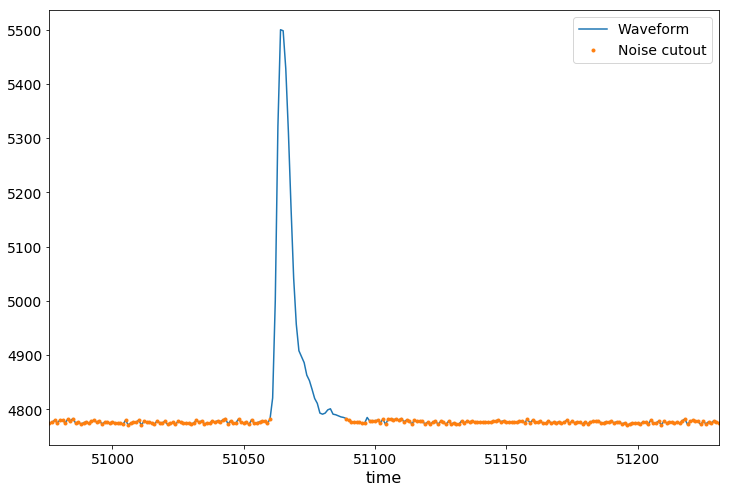

In [6]:
ax = waveforms[list(waveforms)[0]].plot('time', 'adc', label='Waveform')
ax.plot(waveforms[list(waveforms)[0]]['time'][noise[0].index], noise[0], '.', label='Noise cutout')
plt.legend()

Pedestal subtraction

In [7]:
noise = [n - round(n.median()) for n in noise]

Creating one large, concatenated noise sample (maybe not _the_ best idea for FFT)

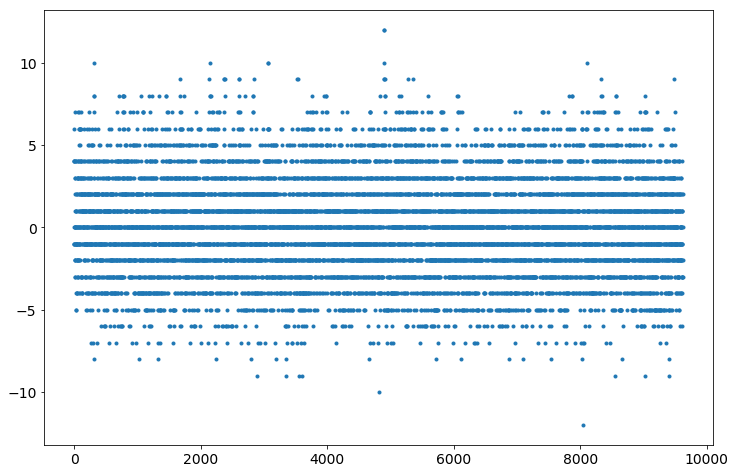

In [8]:
noise = pd.concat(noise, ignore_index=True)
plt.plot(noise, '.')

Text(-9.5, 0.1, 'Noise: 2.93 (ADC units)')

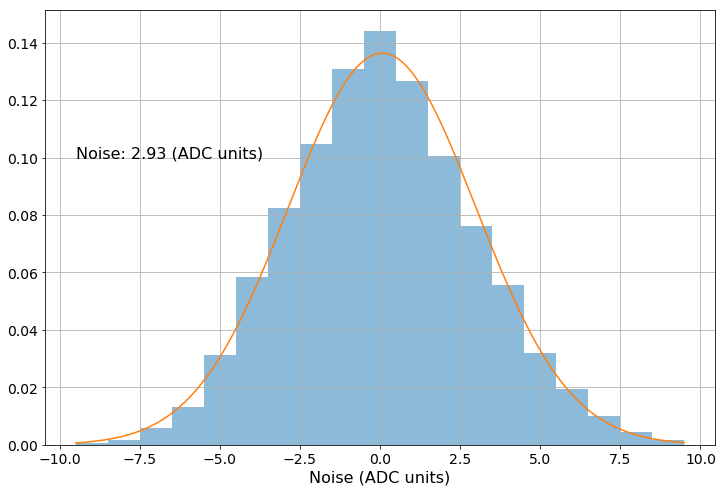

In [9]:
bins = round(noise.mean()) + np.arange(-9.5, 10.5)
x=np.linspace(bins[0], bins[-1], 1000)

noise.hist(bins=bins, density=True, alpha=0.5)

plt.plot(x, stats.norm.pdf(x, loc=noise.mean(), scale=noise.std()))
plt.gca().set_xlabel('Noise (ADC units)')
plt.gca().text(x=bins[0], y = 0.1, s='Noise: %.2f (ADC units)'%noise.std(), fontsize=16)

## FFT (Fast Fourier Transform)

This will transform the noise from the time-domaine into the frequency domain, plotting the power spectrum will allow to identify individual noise sources. In the exampe here there are 4 distinct peaks that can easily be seen, they are known sources.

In [10]:
# T = sampling period in ns
T = waveforms[list(waveforms)[0]]['time'].diff()[1] * 4
N = len(noise)

dfft = pd.DataFrame()
dfft['fft'] = np.fft.rfft(noise)
dfft['amplitude'] = 1 / N * np.abs(dfft['fft'])
dfft['power'] = dfft['amplitude'] ** 2
dfft['frequency'] = np.fft.rfftfreq(N, d=T) * 1e3

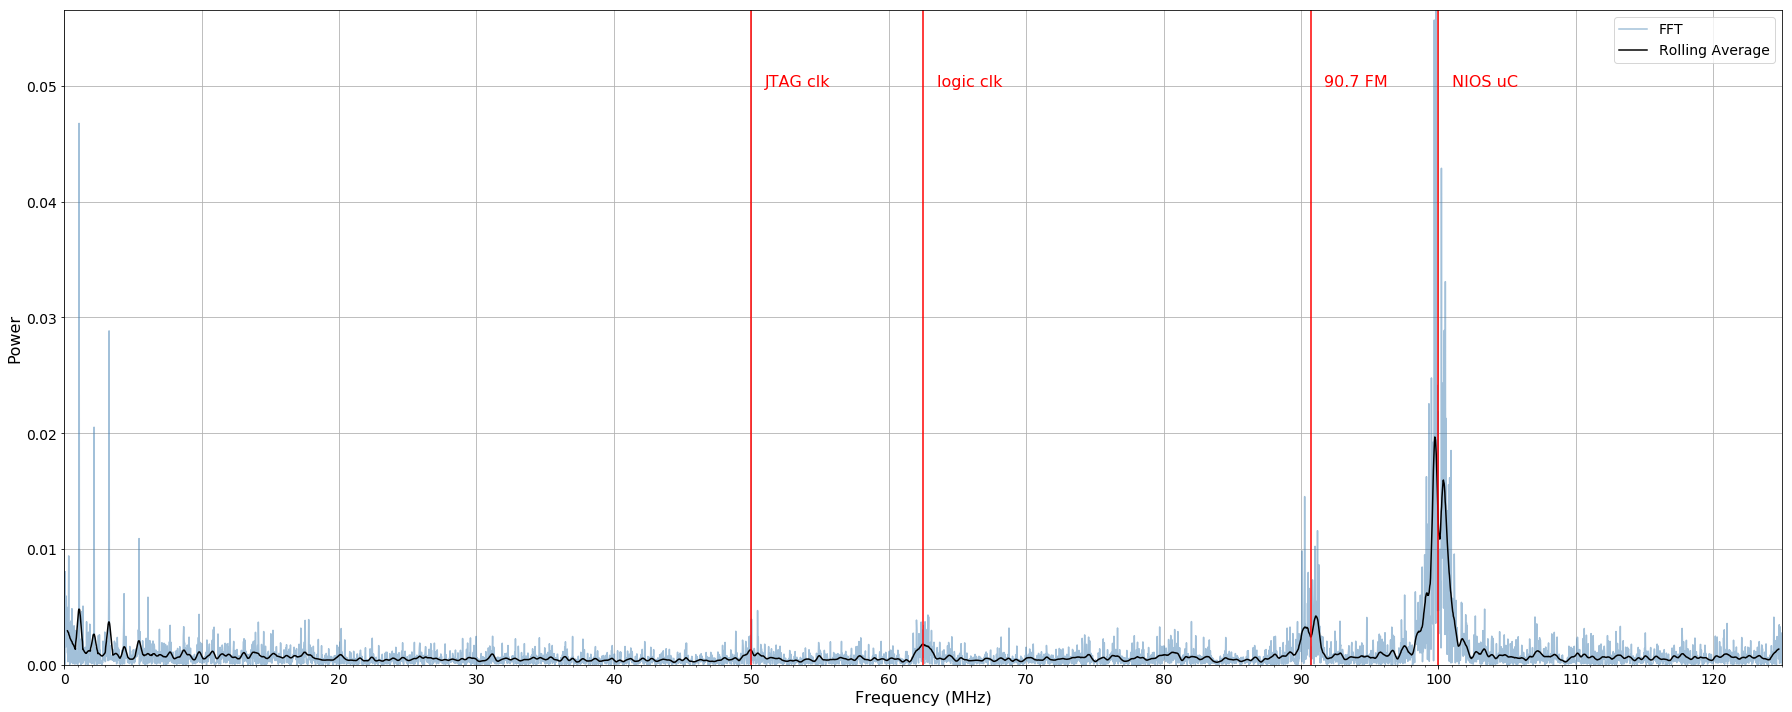

In [11]:
fig, ax = plt.subplots(figsize = (25,10))

dfft.plot('frequency', 'power', ax=ax, label='FFT', c='steelblue', alpha=0.5)
dfft[['frequency', 'power']].rolling(window=20, center=True, win_type='gaussian').mean(std=5).plot('frequency', 'power', ax=ax, label='Rolling Average', alpha=1, color='k')


ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power')
ax.set_ylim([0, dfft['power'].max()])

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid()

plt.tight_layout()

ax.axvline(50, c='r')
ax.text(51, 0.05, s='JTAG clk', fontsize=16, color='r')
ax.axvline(62.5, c='r')
ax.text(63.5, 0.05, s='logic clk', fontsize=16, color='r')
ax.axvline(90.7, c='r')
ax.text(91.7, 0.05, s='90.7 FM', fontsize=16, color='r')
ax.axvline(100, c='r')
ax.text(101, 0.05, s='NIOS uC', fontsize=16, color='r')


plt.savefig('fft.png')

Since 3 out of these 4 sources will be eliminated, we can try to cut them out of the spectrum, do an inverse FFT to get back to the time-domain and re-characterize the noise

In [12]:
mask = ((dfft['frequency'] > 97) & (dfft['frequency'] < 103)) | ((dfft['frequency'] > 49) & (dfft['frequency'] < 51)) | ((dfft['frequency'] > 89.7) & (dfft['frequency'] < 91.7))
dfft['cleaned_fft'] = dfft['fft']
dfft['cleaned_fft'][mask] *= 0
dfft['cleaned_power'] = (1 / N * np.abs(dfft['cleaned_fft'])) ** 2

/home/peller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


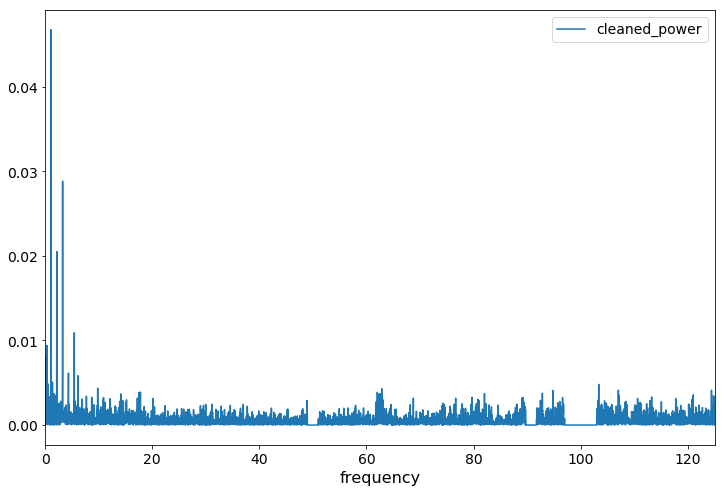

In [13]:
dfft.plot('frequency', 'cleaned_power')

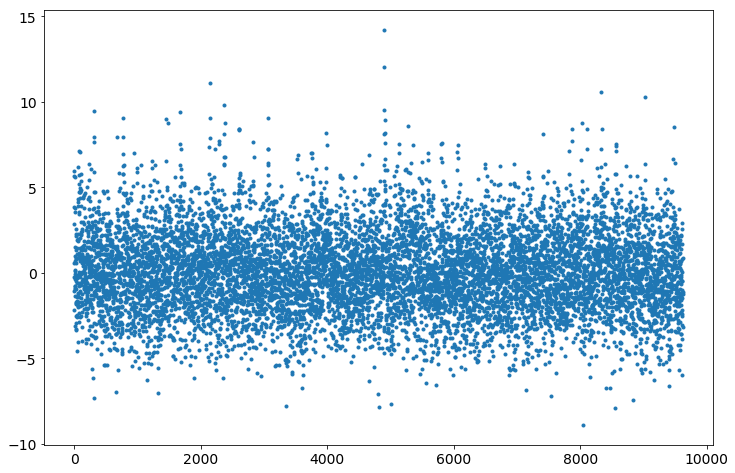

In [14]:
cleaned_noise = pd.Series(np.fft.irfft(dfft['cleaned_fft']))
plt.plot(cleaned_noise, '.')

Text(-9.5, 0.1, 'Noise: 2.39 (ADC units)')

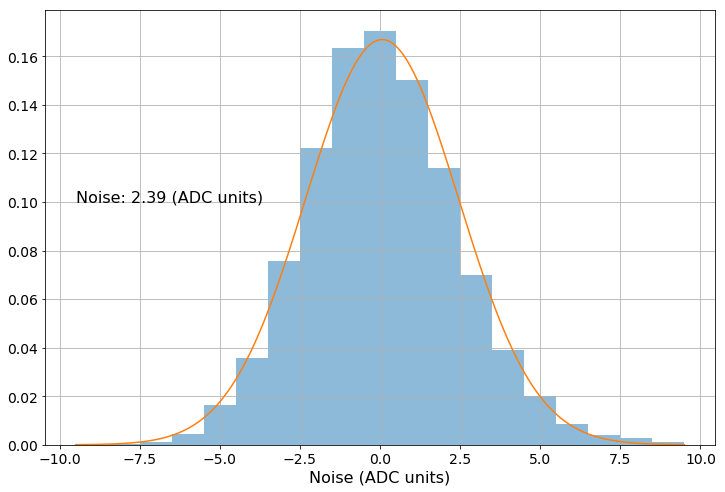

In [15]:
cleaned_noise.hist(bins=bins, density=True, alpha=0.5)
plt.plot(x, stats.norm.pdf(x, loc=cleaned_noise.mean(), scale=cleaned_noise.std()))
plt.gca().set_xlabel('Noise (ADC units)')
plt.gca().text(x=bins[0], y = 0.1, s='Noise: %.2f (ADC units)'%cleaned_noise.std(), fontsize=16)